In [21]:
import torch
import torchvision
import torchvision.transforms as transforms

# transforms.Compose : 이미지에 적용할 여러 변환을 묶는 역할
    # transforms.ToTensor() : 이미지를 텐서로 변환 -> 픽셀 값을 0-255 -> 0-1 사이로 정규화
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) : 각 색상 채널(빨강, 초록, 파랑)의 픽셀 값 범위를 -1 ~ 1 사이로 정규화

transfrom = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256 # 전체(목표) 배치 크기
sub_batch_size = 32 # 부분 배치 크기

# 데이터셋 다운로드
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transfrom)

# 데이터셋 불러오기
# DataLoader : 데이터셋을 배치 단위로 관리하는 역할
    # batch_size : 배치 크기
    # shuffle : 데이터를 섞을지 여부
    # num_workers : 데이터 로드에 사용할 쓰레드 수
train_loader = torch.utils.data.DataLoader(trainset, batch_size=sub_batch_size, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

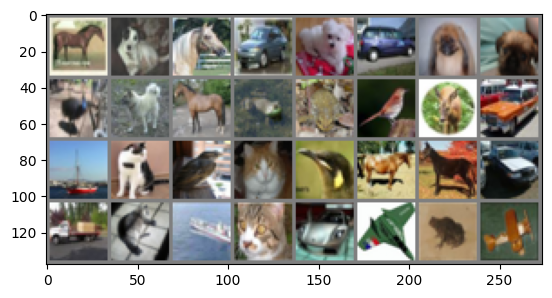

horse   dog horse   car   dog   car   dog   dog  bird   dog horse  frog  frog  bird  deer   car  ship   cat  bird   cat  bird horse horse   car truck   cat  ship   cat   car plane  frog plane


In [22]:
# 데이터 확인
import matplotlib.pyplot as plt
import numpy as np

# 이미지 시각화 함수
def imshow(img):
    img = img / 2 + 0.5 # 정규화된 이미지를 0-1 사이로 변환
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 하나의 batch 데이터 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)


# torchvision.utils.make_grid : 여러 이미지를 하나의 그림으로 결합
imshow(torchvision.utils.make_grid(images))

# 레이블 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(sub_batch_size)))

In [23]:
import torch.nn as nn
import torch.nn.functional as F

# PlainNetBlock : 18 layer plain net의 기본 블록
class PlainNetBlock(nn.Module):
    expansion = 1

    # 초기화 함수
    def __init__(self, in_planes, planes, stride=1):
        super(PlainNetBlock, self).__init__()

        # 첫 번째 컨볼루션 레이어
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # 두 번째 컨볼루션 레이어
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return out

# ResNetBasicBlock : ResNet의 기본 블록
class ResNetBasicBlock(nn.Module):
    expansion = 1

    # 초기화 함수
    def __init__(self, in_planes, planes, stride=1):
        super(ResNetBasicBlock, self).__init__()

        # 첫 번째 컨볼루션 레이어
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # 두 번째 컨볼루션 레이어
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # 축약 경로(shortcut) 설정
        self.shortcut = nn.Sequential()

        # Input 크기가 변경되는 경우, Output 크기와 일치시키기 위해 1x1 컨볼루션 추가
        if stride != 1 or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )
    
    # 순전파 함수
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # 축약 경로 추가
        out = F.relu(out)
        return out

In [24]:
# net class
class Net(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(Net, self).__init__()
        self.in_planes = 64

        # 채널 수 3 -> 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # _make_layer 함수 호출하여 여러 개의 블록 그룹 생성
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # average pooling 레이어 사용
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # 완전 연결 레이어(Fully Connected Layer) 512 * block.expansion -> 10개의 클래스로 분류
        self.fc = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1) # 첫 번째 블록은 stride, 나머지는 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion # 채널 수 증가
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)  # 텐서를 평탄화 (배치 크기, 512)
        out = self.fc(out)
        return out

In [25]:
# 18 layer plain net
planet_18 = Net(PlainNetBlock, [2, 2, 2, 2])
planet_18_loss = []
planet_18_error = []
    
# 18 layer resnet
resnet_18 = Net(ResNetBasicBlock, [2, 2, 2, 2])
resnet_18_loss = []
resnet_18_error = []

In [26]:
import torch.optim as optim

# 크로스 엔트로피 손실 함수 사용
criterion = nn.CrossEntropyLoss()

# 학습률 0.0001, 모멘텀 0.9
planet_18_optimizer = optim.SGD(planet_18.parameters(), lr=0.0001, momentum=0.9)
resnet_18_optimizer = optim.SGD(resnet_18.parameters(), lr=0.0001, momentum=0.9)

# 3번 에포크 학습
num_epochs = 3

In [ ]:
# model 학습
for epoch in range(num_epochs):
    running_loss_planet_18 = 0.0
    running_loss_resnet_18 = 0.0
    accumulated_steps = batch_size // sub_batch_size # 누적 배치 크기
    
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # 순전파 + 역전파 + 최적화
        outputs_planet_18 = planet_18(inputs)
        outputs_resnet_18 = resnet_18(inputs)

        loss_planet_18 = criterion(outputs_planet_18, labels)
        loss_resnet_18 = criterion(outputs_resnet_18, labels)

        loss_planet_18.backward()
        loss_resnet_18.backward()

        # 배치 손실 합계 계산
        running_loss_planet_18 += loss_planet_18.item()
        running_loss_resnet_18 += loss_resnet_18.item()

        # 8번마다 파라미터 업데이트(256/32 = 8) -> gradient 누적
        if (i + 1) % accumulated_steps == 0:
            ## planet_18
            planet_18_optimizer.step() # 파라미터 업데이트
            planet_18_optimizer.zero_grad() # 변화도(gradient) 초기화
            
            ## resnet_18
            resnet_18_optimizer.step() # 파라미터 업데이트
            resnet_18_optimizer.zero_grad() # 변화도(gradient) 초기화

            # 매번 손실 기록 (8번의 배치 평균)
            avg_loss_planet_18 = running_loss_planet_18 / accumulated_steps
            planet_18_loss.append(avg_loss_planet_18)

            avg_loss_resnet_18 = running_loss_resnet_18 / accumulated_steps
            resnet_18_loss.append(avg_loss_resnet_18)
            
            # 오류율 계산 (마지막 배치의 예측 정확도)
            _, predicted_planet_18 = torch.max(outputs_planet_18.data, 1)
            correct_planet_18 = (predicted_planet_18 == labels).sum().item()
            total_planet_18 = labels.size(0)
            error_rate_planet_18 = (1 - correct_planet_18 / total_planet_18) * 100  # 오류율 (%)
            planet_18_error.append(error_rate_planet_18)

            _, predicted_resnet_18 = torch.max(outputs_resnet_18.data, 1)
            correct_resnet_18 = (predicted_resnet_18 == labels).sum().item()
            total_resnet_18 = labels.size(0)
            error_rate_resnet_18 = (1 - correct_resnet_18 / total_resnet_18) * 100  # 오류율 (%)
            resnet_18_error.append(error_rate_resnet_18)
            
            print(f"Step {i // accumulated_steps + 1}: planet_18 Loss = {avg_loss_planet_18:.4f}, planet_18 Error = {error_rate_planet_18:.2f}, resnet_18 Loss = {avg_loss_resnet_18:.4f}, resnet_18 Error = {error_rate_resnet_18:.2f}")
            
            # running_loss 초기화 (다음 8번의 배치를 위해)
            running_loss_planet_18 = 0.0
            running_loss_resnet_18 = 0.0
    # 학습 루프가 끝난 후, 남은 그래디언트 처리
    if (len(train_loader) % accumulated_steps) != 0:
        planet_18_optimizer.step()
        planet_18_optimizer.zero_grad()

        resnet_18_optimizer.step()  
        resnet_18_optimizer.zero_grad()


Epoch 1/3
Step 1: planet_18 Loss = 2.2993, planet_18 Error = 81.25, resnet_18 Loss = 2.3923, resnet_18 Error = 100.00
Step 2: planet_18 Loss = 2.3082, planet_18 Error = 93.75, resnet_18 Loss = 2.3826, resnet_18 Error = 93.75
Step 3: planet_18 Loss = 2.2756, planet_18 Error = 90.62, resnet_18 Loss = 2.3504, resnet_18 Error = 93.75
Step 4: planet_18 Loss = 2.2664, planet_18 Error = 68.75, resnet_18 Loss = 2.3279, resnet_18 Error = 84.38
Step 5: planet_18 Loss = 2.2465, planet_18 Error = 87.50, resnet_18 Loss = 2.2567, resnet_18 Error = 78.12
Step 6: planet_18 Loss = 2.2410, planet_18 Error = 90.62, resnet_18 Loss = 2.2881, resnet_18 Error = 90.62
Step 7: planet_18 Loss = 2.2378, planet_18 Error = 81.25, resnet_18 Loss = 2.2301, resnet_18 Error = 93.75
Step 8: planet_18 Loss = 2.1919, planet_18 Error = 93.75, resnet_18 Loss = 2.2013, resnet_18 Error = 90.62
Step 9: planet_18 Loss = 2.2201, planet_18 Error = 87.50, resnet_18 Loss = 2.2557, resnet_18 Error = 78.12
Step 10: planet_18 Loss =

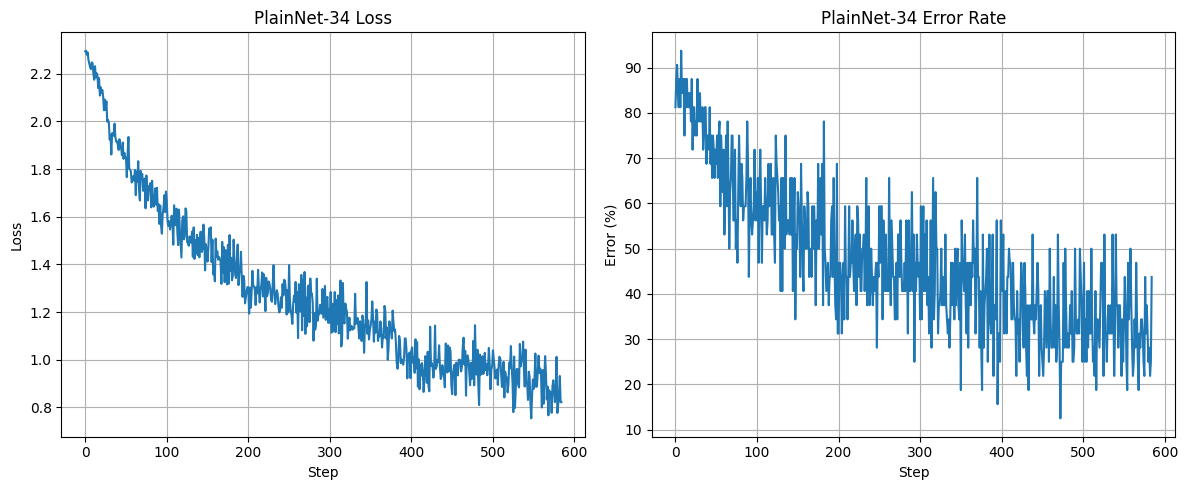

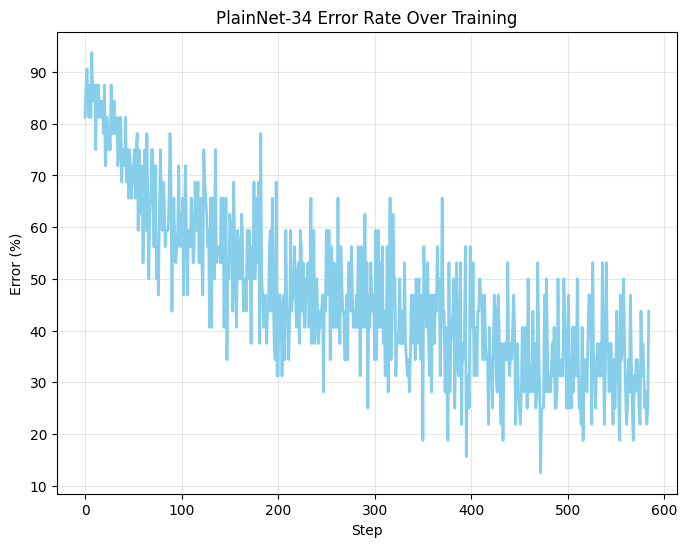

In [ ]:
# PlainNet과 ResNet 비교 그래프
plt.figure(figsize=(15, 5))

# 손실 비교 그래프
plt.subplot(1, 3, 1)
plt.plot(plain_net_loss, label='PlainNet-18', color='blue', linewidth=2)
plt.plot(resnet_18_loss, label='ResNet-18', color='red', linewidth=2)
plt.title("Loss Comparison")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# 오류율 비교 그래프
plt.subplot(1, 3, 2)
plt.plot(plain_net_error, label='PlainNet-18', color='blue', linewidth=2)
plt.plot(resnet_18_error, label='ResNet-18', color='red', linewidth=2)
plt.title("Error Rate Comparison")
plt.xlabel("Step")
plt.ylabel("Error (%)")
plt.legend()
plt.grid(True, alpha=0.3)

# 오류율만 따로 비교 (더 큰 그래프)
plt.subplot(1, 3, 3)
plt.plot(plain_net_error, label='PlainNet-18', color='blue', linewidth=2, marker='o', markersize=3)
plt.plot(resnet_18_error, label='ResNet-18', color='red', linewidth=2, marker='s', markersize=3)
plt.title("Error Rate Comparison (Detailed)")
plt.xlabel("Step")
plt.ylabel("Error (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# ResNet-18 학습
resnet_optimizer = optim.SGD(resnet_18.parameters(), lr=0.0001, momentum=0.9)

for epoch in range(num_epochs):
    running_loss = 0.0
    accumulated_steps = batch_size // sub_batch_size
    
    print(f"\nResNet Epoch {epoch + 1}/{num_epochs}")
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # 순전파 + 역전파 + 최적화
        outputs = resnet_18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # 배치 손실 합계 계산
        running_loss += loss.item()

        # 8번마다 파라미터 업데이트(256/32 = 8) -> gradient 누적
        if (i + 1) % accumulated_steps == 0:
            resnet_optimizer.step() # 파라미터 업데이트
            resnet_optimizer.zero_grad() # 변화도(gradient) 초기화
            
            # 매번 손실 기록 (8번의 배치 평균)
            avg_loss = running_loss / accumulated_steps
            resnet_18_loss.append(avg_loss)
            
            # 오류율 계산 (마지막 배치의 예측 정확도)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            total = labels.size(0)
            error_rate = (1 - correct / total) * 100  # 오류율 (%)
            resnet_18_error.append(error_rate)
            
            print(f"Step {i // accumulated_steps + 1}: Loss = {avg_loss:.4f}, Error = {error_rate:.2f}%")
            
            # running_loss 초기화 (다음 8번의 배치를 위해)
            running_loss = 0.0
    # 학습 루프가 끝난 후, 남은 그래디언트 처리
    if (len(train_loader) % accumulated_steps) != 0:
        resnet_optimizer.step()
        resnet_optimizer.zero_grad()


In [ ]:
# PlainNet과 ResNet 비교 그래프
plt.figure(figsize=(15, 5))

# 손실 비교 그래프
plt.subplot(1, 3, 1)
plt.plot(plain_net_loss, label='PlainNet-18', color='blue', linewidth=2)
plt.plot(resnet_18_loss, label='ResNet-18', color='red', linewidth=2)
plt.title("Loss Comparison")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# 오류율 비교 그래프
plt.subplot(1, 3, 2)
plt.plot(plain_net_error, label='PlainNet-18', color='blue', linewidth=2)
plt.plot(resnet_18_error, label='ResNet-18', color='red', linewidth=2)
plt.title("Error Rate Comparison")
plt.xlabel("Step")
plt.ylabel("Error (%)")
plt.legend()
plt.grid(True, alpha=0.3)

# 오류율만 따로 비교 (더 큰 그래프)
plt.subplot(1, 3, 3)
plt.plot(plain_net_error, label='PlainNet-18', color='blue', linewidth=2, marker='o', markersize=3)
plt.plot(resnet_18_error, label='ResNet-18', color='red', linewidth=2, marker='s', markersize=3)
plt.title("Error Rate Comparison (Detailed)")
plt.xlabel("Step")
plt.ylabel("Error (%)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
